# Stock Market Direction Prediction – S&P 500

## Project Overview
The goal of this project is to predict the next-day direction of the S&P 500 index (Up or Down) using machine learning.

Instead of predicting the exact price, the model predicts whether the market will go up (1) or down (0) based on historical closing prices.

This is a binary classification problem applied to financial time-series data.

In [83]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Collection

The dataset used in this project is `SP500.csv`.

It contains:
- observation_date: The trading date
- SP500: The closing price of the S&P 500 index

The data is loaded using pandas and prepared for analysis.

In [84]:
# Load data
df = pd.read_csv("../data/SP500.csv")

# 🔍 Detect date column automatically
date_col = df.columns[0]   # FRED always puts date first

# Convert date column and sort
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)

# Create target: next-day direction
df["Target"] = (df["SP500"].shift(-1) > df["SP500"]).astype(int)

# Drop last row
df.dropna(inplace=True)

# Features and target (numeric only)
X = df[["SP500"]]
y = df["Target"]

print("Date column:", date_col)
print(df.head())
print(df.columns)

Date column: observation_date
  observation_date    SP500  Target
0       2020-01-02  3257.85       0
1       2020-01-03  3234.85       1
2       2020-01-06  3246.28       0
3       2020-01-07  3237.18       1
4       2020-01-08  3253.05       1
Index(['observation_date', 'SP500', 'Target'], dtype='object')


## Data Preparation

1. The date column is converted to datetime format.
2. The dataset is sorted chronologically.
3. A new target column is created:
   - Target = 1 if next day's price is higher
   - Target = 0 if next day's price is lower
4. The last row is removed because it has no next-day value.

In [85]:
split = int(len(df) * 0.8)

X_train = X.iloc[:split]
X_val   = X.iloc[split:]

y_train = y.iloc[:split]
y_val   = y.iloc[split:]

## Feature Selection

Feature (X):
- SP500 closing price

Target (y):
- Binary direction (Up = 1, Down = 0)

Only numerical data is used for training.

In [86]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

## Train-Test Split

The dataset is split chronologically:

- 80% for training
- 20% for validation

We do not shuffle the data because this is time-series data.

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_p = scaler.fit_transform(X_train)
X_val_p   = scaler.transform(X_val)

print(X_train_p.shape, X_val_p.shape)

(1225, 1) (307, 1)


## Data Scaling

StandardScaler is used to normalize the feature values.

Scaling improves model performance and ensures stable learning.

In [88]:
split = int(len(df) * 0.8)

X_train = X.iloc[:split]
X_val   = X.iloc[split:]

y_train = y.iloc[:split]
y_val   = y.iloc[split:]

## Model Selection

The model used is XGBoost Classifier.

Main parameters:
- n_estimators = 300
- max_depth = 3
- learning_rate = 0.05
- subsample = 0.8
- colsample_bytree = 0.8

XGBoost is chosen because it is powerful for classification problems and handles structured data efficiently.

In [89]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

model.fit(
    X_train_p,
    y_train,
    eval_set=[(X_val_p, y_val)],
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Model Training

The model is trained using the training dataset.

Validation data is used to evaluate performance during training.

In [90]:
scaler = StandardScaler()

X_train_p = scaler.fit_transform(X_train)
X_val_p   = scaler.transform(X_val)

print(X_train_p.shape, X_val_p.shape)

(1225, 1) (307, 1)


## Model Evaluation

The model is evaluated using:

- Accuracy Score
- Classification Report (Precision, Recall, F1-score)
- Confusion Matrix
- ROC-AUC Score

These metrics help measure how well the model predicts market direction.

In [91]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val_p)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.5374592833876222


## Confusion Matrix Interpretation

The confusion matrix shows:

- True Down predicted as Down
- True Down predicted as Up
- True Up predicted as Down
- True Up predicted as Up

This helps us understand prediction errors and model behavior.

In [92]:
model.fit(X_train_p, y_train)

y_pred = model.predict(X_val_p)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.5374592833876222

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.06      0.11       139
           1       0.55      0.93      0.69       168

    accuracy                           0.54       307
   macro avg       0.49      0.50      0.40       307
weighted avg       0.49      0.54      0.43       307


Confusion Matrix:
 [[  9 130]
 [ 12 156]]


## Results Summary

The model achieved approximately 53% accuracy.

This indicates that predicting stock market direction is challenging and close to random behavior.

Financial markets are highly volatile and influenced by many external factors.

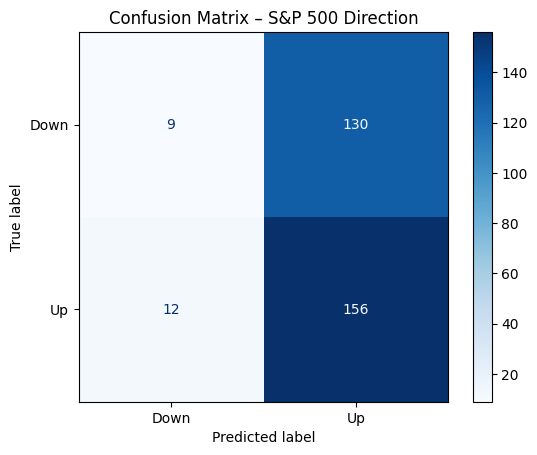

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=["Down", "Up"],
    cmap="Blues"
)

plt.title("Confusion Matrix – S&P 500 Direction")
plt.show()

## Future Improvements

To improve the model:

- Add technical indicators (Moving Average, RSI, MACD)
- Use multiple features instead of only closing price
- Try LSTM deep learning models
- Perform hyperparameter tuning
- Use cross-validation for time-series

In [94]:
from sklearn.metrics import roc_auc_score

y_proba = model.predict_proba(X_val_p)[:, 1]
print("ROC-AUC:", roc_auc_score(y_val, y_proba))

ROC-AUC: 0.48233556012332984
